# Зотов Алексей

In [16]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [17]:
!ls

README.md      solution.ipynb


Используем набор данных партий игр в крестики нолики (tic-tac-toe). Целью является показать победил ли игрок ходивший первым.

In [19]:
df = pd.read_csv("data/tic-tac-toe.csv", sep=',', names = list(range(9)) + ['target'])
df.head()

,0,1,2,3,4,5,6,7,8,target
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


Проведем бинаризацию признаков.

In [20]:
import copy
def dummy_encode_categorical_columns(data):
    result_data = copy.deepcopy(data)
    for column in data.columns.values:
        result_data = pd.concat(
            [result_data, pd.get_dummies(result_data[column],
                                         prefix = column, prefix_sep = '_')], axis = 1)
        del result_data[column]
    return result_data
df = dummy_encode_categorical_columns(df)
df['target'] = df['target_positive']
df = df.drop(['target_positive', 'target_negative'], axis=1)
df.head()

,0_b,0_o,0_x,1_b,1_o,1_x,2_b,2_o,2_x,3_b,...,6_b,6_o,6_x,7_b,7_o,7_x,8_b,8_o,8_x,target
0,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,1,0,0,1,0,1
1,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,1
2,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,1
3,0,0,1,0,0,1,0,0,1,0,...,0,1,0,1,0,0,1,0,0,1
4,0,0,1,0,0,1,0,0,1,0,...,1,0,0,0,1,0,1,0,0,1


Разделим исходные данные на обучающую и контрольную подвыборки в отношении 7:3.

In [21]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.3)
len(df_train), len(df_test)

(670, 288)

In [22]:
X_train, y_train = df_train.drop(['target'], axis=1), df_train['target']
X_test, y_test = df_test.drop(['target'], axis=1), df_test['target']

В предложенной реализации удобно разделить объекты из негативного и позитивного контекстовю

In [23]:
X_train_pos = np.array(X_train[y_train == 1])
X_train_neg = np.array(X_train[y_train == 0])

Для настройки уровня влияния поддержки и достоверности введем вспомогательный коэффициент.

In [50]:
RECALL_RATIO = 0.35

Реализуем предложенный простой вариант алгоритма.

In [51]:
def print_apc(metrics) :
    print('accuracy {}'.format(metrics[0]))
    print('precision {}'.format(metrics[1]))
    print('recall {}'.format(metrics[2]))
    
def get_impact_baseline(obj, X):
    impact = 0
    for x in X:
        common_ids = (obj == x)
        closure_power = np.sum(np.all(obj[common_ids] == X[:, common_ids], axis=1)) - 1
        assert(closure_power >= 0)
        impact += closure_power 
    return impact

def apply_baseline():
    y_pred = np.zeros(len(X_test), dtype=np.int32)
    for i, test_obj in tqdm(enumerate(np.array(X_test)), position=0):
        positive_impact = get_impact_baseline(test_obj, X_train_pos)
        negative_impact = get_impact_baseline(test_obj, X_train_neg)
        y_pred[i] = (positive_impact * RECALL_RATIO > negative_impact)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    return accuracy, precision, recall

In [52]:
print_apc(apply_baseline())

288it [00:03, 83.02it/s]

accuracy 0.7326388888888888
precision 0.7389380530973452
recall 0.9027027027027027


Усовершенствуем алгоритм.

Нормализуем величину поддержки/влияния на размер контекста. 


Положим вес(weight) каждого замыкания пропорционально размеру пересечения. 

Введем параметр weight_power.

Итоговый вес будет вычисляться как степенная функция от веса(weight) с показателем weight_power. 

In [55]:
RECALL_RATIO = 0.8

def get_impact(obj, X, weight_power):
    impact = 0
    for x in X:
        common_ids = (obj == x)
        weight = np.sum(common_ids) / len(common_ids)
        closure_power = np.sum(np.all(obj[common_ids] == X[:, common_ids], axis=1)) - 1
        assert(closure_power >= 0)
        impact += closure_power * (weight**weight_power)
    impact /= len(X)
    return impact
    
def apply(weight_power):
    y_pred = np.zeros(len(X_test), dtype=np.int32)
    for i, test_obj in tqdm(enumerate(np.array(X_test)), position=0):
        positive_impact = get_impact(test_obj, X_train_pos, weight_power)
        negative_impact = get_impact(test_obj, X_train_neg, weight_power)
        y_pred[i] = (positive_impact * RECALL_RATIO > negative_impact)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    return accuracy, precision, recall

In [56]:
accuracy, precision, recall = apply(5)
print("acc : {}, precision : {}, recall : {}".format(accuracy, precision, recall))

288it [00:05, 50.62it/s]

acc : 0.8333333333333334, precision : 0.8071748878923767, recall : 0.972972972972973


Результат заметно лучше по всем метрикам.

Подберем оптимальный параметр weight_power.

In [57]:
weight_power_range = [2, 3, 4, 8, 16, 20, 25, 28, 32, 45, 55, 64]
accuracy_all, precision_all, recall_all = [], [], []
for weight_power in weight_power_range:
    accuracy, precision, recall = apply(weight_power)
    accuracy_all.append(accuracy)
    precision_all.append(precision)
    recall_all.append(recall)    

288it [00:05, 48.93it/s]
288it [00:05, 50.57it/s]
288it [00:05, 53.08it/s]
288it [00:05, 53.61it/s]
288it [00:05, 51.93it/s]
288it [00:05, 54.33it/s]
288it [00:05, 51.56it/s]
288it [00:05, 52.48it/s]
288it [00:05, 50.89it/s]
288it [00:05, 51.51it/s]
288it [00:05, 52.76it/s]
288it [00:05, 52.55it/s]


In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

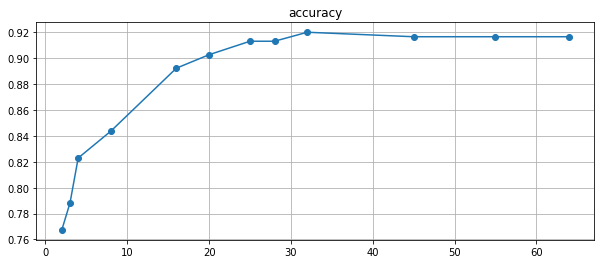

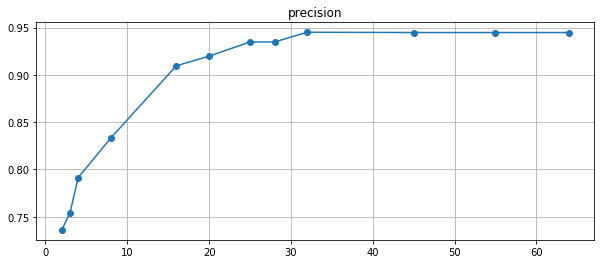

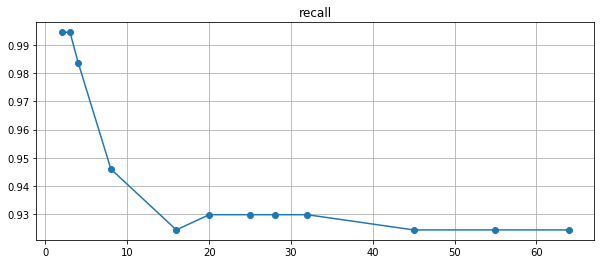

In [62]:
metrics = (accuracy_all, precision_all, recall_all)
names = ("accuracy", "precision", "recall")
for name, metric in zip(names, metrics):
    plt.figure(figsize=(10,4))
    plt.grid(True)
    plt.title(name)
    plt.plot(weight_power_range, metric, '-o')
    plt.show()

При данной точности измерений, оптимальной точкой получиась weight_po

In [ ]:
accuracy, precision, recall = apply(5)